#  Modelo de ZeeHB

Sample of notebook for specific model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
import hep as hp

In [3]:
def func(s2phi, M1, M2, MAo, Mho, MHo, v, lam2, lam6, lam7, lam9, lam10, lamh, Muh, Mu2):
    M12 = M1*M1; M22 = M2*M2; MAo2 = MAo*MAo; Mho2 = Mho*Mho; MHo2 = MHo*MHo; Mu22 = Mu2*Mu2; Muh2 = Muh*Muh     
    k = s2phi*np.log(M22/M12)/(4.*np.pi)**2
    phi = 0.5*np.arcsin(s2phi)
    Mu  = (M22-M12)*s2phi/(np.sqrt(2.0)*v)
    MH2 = M12*(np.sin(phi))**2+M22*(np.cos(phi))**2
    M332 = M12*(np.cos(phi))**2+M22*(np.sin(phi))**2
    lam1 = 0.5*(MHo2+Mho2-np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2))/(v**2)
    lam3 = 2.0*(MH2-Mu22)/(v**2)
    lam4 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2+2.0*(MAo2-2.0*MH2))/(v**2)
    lam5 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2-2.0*MAo2)/(v**2)
    lam8 = 2.0*(M332-Muh2)/(v**2)
    return k, Mu, lam1, lam3, lam4, lam5, lam8

In [16]:
def Inverse_Zee_Matrix(kappa,ml,IH=False,sgnm2=-1,sgnml=1):
    """Inverse neutrino mass matrix normalized by kappa from
        Mnu_diag=U^T.(kappa Y).U
        ,
        (Inverse_Zee_Matrix) = U. Mnu_diag.U^T/kappa
        sgnm2=-1 guarantees real Yukawa couplings
        
    requires hep.py:
       https://github.com/restrepo/BSM-Toolbox/blob/master/tests/hep.py
    """
    if not IH:
        mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data()
        U=hp.UPMNS(theta12[1],theta13[1],theta23[1])
        m1=ml; m2=sgnm2*np.sqrt(Dm21_2[1]+m1**2); m3=sgnml*np.sqrt(Dm3l_2[1]+m1**2)
    else:
        mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data(IH=True)
        U=hp.UPMNS(theta12[1],theta13[1],theta23[1])
        #DEBUG signs
        m3=ml; m2=sgnm2*np.sqrt(Dm3l_2[1]-m3**2); m1=sgnml*np.sqrt(Dm21_2[1]-m2**2)
        
    return np.dot( np.dot( U,np.diag([m1,m2,m3]) ), U.transpose() )/kappa

def get_yukawas(X,q01=1e-3,q02=1e-6,q10=200e-3,q12=0,q21=-1e-5,q22=0,m_e=0.5109989461e-3,m_mu=0.1056583745,m_tau=1.77686,):
    """
    Get the O and f full Yukawa mass matrices which define the neutrino mass matrix in the Zee model
      Mnu=kappa*(O.M_lep.f^T+f.M_lep.O^T)
    where M_lep is the diagonal matrix with the charged leptons
    
    The input X is the output of the `def Inverse_Zee_Matrix(...)` in this module
    """
    import numpy.lib.scimath as sc # .sqrt -> returns complex for sqrt(negative real)
    ml=np.array([m_e,m_mu,m_tau])
    Q=np.zeros((3,3))
    f=np.zeros((3,3))
    Q[0,1]=q01;Q[0,2]=q02;Q[1,0]=q10;Q[1,2]=q12;Q[2,1]=q21;Q[2,2]=q22
    Q[2,0]=( -(ml[0]**3*Q[1,0]**2*X[0,0]**2*(ml[1]*Q[2,1]*X[0,1] + ml[2]*Q[0,2]*X[2,2])) -\
      ml[0]*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2])*(ml[1]*Q[0,1]*((ml[1]*Q[0,1]*X[0,1] +\
      ml[2]*Q[0,2]*X[0,2])*X[1,1] + ml[2]*Q[1,2]*X[0,0]*X[1,2]) +\
      ml[2]**2*Q[0,2]*Q[1,2]*X[0,0]*X[2,2]) + ml[0]**2*Q[1,0]*X[0,0]*(-(ml[1]*Q[2,1]*((2*ml[1]*Q[0,1]*X[0,1] +\
      ml[2]*Q[0,2]*X[0,2])*X[1,1] + ml[2]*Q[1,2]*X[0,0]*X[1,2])) -\
      ml[2]*(2*ml[2]*Q[0,2]*Q[1,2]*X[0,2] + ml[1]*Q[0,1]*(Q[1,2]*X[0,1] + Q[0,2]*X[1,1]))*X[2,2]) +\
      np.sqrt( -(ml[0]**2*ml[1]**2*(ml[0]*Q[1,0]*Q[2,1]*X[0,0] + Q[0,1]*(ml[1]*Q[2,1]*X[1,1] +\
      ml[2]*Q[1,2]*X[2,2]))**2*(ml[0]**2*Q[1,0]**2*X[0,0]**2*(-X[0,1]**2 + X[0,0]*X[1,1]) +\
      ml[1]**2*Q[0,1]**2*X[1,1]**2*(-X[0,1]**2 + X[0,0]*X[1,1]) +\
      2*ml[1]*ml[2]*Q[0,1]*X[1,1]*((Q[1,2]*X[0,0] - Q[0,2]*X[0,1])*X[0,2]*X[1,1] + X[0,0]*(-(Q[1,2]*X[0,1]) +\
      Q[0,2]*X[1,1])*X[1,2]) + 2*ml[0]*Q[1,0]*X[0,0]*(X[1,1]*(ml[2]*(Q[1,2]*X[0,0] - Q[0,2]*X[0,1])*X[0,2] +\
      ml[1]*Q[0,1]*(-X[0,1]**2 + X[0,0]*X[1,1])) + ml[2]*X[0,0]*(-(Q[1,2]*X[0,1]) + Q[0,2]*X[1,1])*X[1,2]) +\
      ml[2]**2*(-(Q[0,2]*X[0,2]*X[1,1] - Q[1,2]*X[0,0]*X[1,2])**2 + X[0,0]*X[1,1]*(Q[1,2]**2*X[0,0] -\
      2*Q[0,2]*Q[1,2]*X[0,1] + Q[0,2]**2*X[1,1])*X[2,2])))    )   )/\
      (ml[0]**2*X[0,0]*((ml[0]*Q[1,0]*X[0,0] + ml[1]*Q[0,1]*X[1,1])*(ml[0]*Q[1,0]*X[0,0] +\
       2*ml[2]*Q[1,2]*X[0,2] + ml[1]*Q[0,1]*X[1,1]) + ml[2]**2*Q[1,2]**2*X[0,0]*X[2,2]))

    Q[0,0]=(ml[0]**2*Q[0,1]*Q[1,0]*Q[2,0]*X[0,0] - ml[2]*(Q[0,2]*Q[2,1] -\
        Q[0,1]*Q[2,2])*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2]) +\
        ml[0]*(ml[1]*Q[0,1]**2*Q[2,0]*X[1,1] + ml[2]*(Q[1,2]*Q[2,0]*(-(Q[2,1]*X[0,0]) +\
        2*Q[0,1]*X[0,2]) + Q[1,0]*(Q[2,1]*(Q[2,2]*X[0,0] - 2*Q[0,2]*X[0,2]) +\
        Q[0,1]*Q[0,2]*X[2,2]))))/(ml[0]*(ml[0]*Q[1,0]*Q[2,1]*X[0,0] +\
        Q[0,1]*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2])))
    
    Q[1,1]=(ml[0]**3*Q[1,0]*Q[2,0]*(Q[0,1]*Q[1,2]*Q[2,0] - Q[0,2]*Q[1,0]*Q[2,1])*X[0,0]**2 +\
        ml[0]*(2*ml[1]*Q[0,1]*(Q[0,1]*Q[1,2]*Q[2,0]*X[0,1] + Q[1,0]*Q[2,1]*(Q[1,2]*X[0,0] -\
        Q[0,2]*X[0,1])) + ml[2]*(Q[0,1]*Q[1,2]*Q[2,0]*Q[2,2]*X[0,0] -\
        2*Q[0,2]**2*Q[1,0]*Q[2,1]*X[0,2] + Q[0,2]*(Q[1,0]*Q[2,1]*Q[2,2]*X[0,0] +\
        2*Q[1,2]*Q[2,0]*(-(Q[2,1]*X[0,0]) + Q[0,1]*X[0,2]))))*(ml[1]*Q[2,1]*X[1,1] +\
        ml[2]*Q[1,2]*X[2,2]) + (ml[1]*Q[0,1]**2*Q[1,2] + ml[2]*Q[0,2]*(-(Q[0,2]*Q[2,1]) +\
        Q[0,1]*Q[2,2]))*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2])**2 +\
        ml[0]**2*X[0,0]*(ml[1]*(Q[1,0]**2*Q[2,1]**2*(Q[1,2]*X[0,0] - 2*Q[0,2]*X[0,1]) +\
        Q[0,1]**2*Q[1,2]*Q[2,0]**2*X[1,1] + Q[0,1]*Q[1,0]*Q[2,0]*Q[2,1]*(2*Q[1,2]*X[0,1] -\
        Q[0,2]*X[1,1])) + ml[2]*(Q[1,2]**2*Q[2,0]**2*(-(Q[2,1]*X[0,0]) + 2*Q[0,1]*X[0,2]) -\
        Q[0,2]**2*Q[1,0]**2*Q[2,1]*X[2,2] + Q[1,0]*Q[1,2]*Q[2,0]*(Q[2,1]*(Q[2,2]*X[0,0] -\
        2*Q[0,2]*X[0,2]) + Q[0,1]*Q[0,2]*X[2,2]))))/\
        (ml[1]*(ml[0]*Q[1,0]*Q[2,1]*X[0,0] + Q[0,1]*(ml[1]*Q[2,1]*X[1,1] +\
         ml[2]*Q[1,2]*X[2,2]))*(ml[0]*Q[1,2]*Q[2,0]*X[0,0] + Q[0,2]*(ml[1]*Q[2,1]*X[1,1] +\
         ml[2]*Q[1,2]*X[2,2])))    
        
    f[0,1]=(ml[0]*Q[1,2]*Q[2,0]*X[0,0] + ml[1]*Q[0,2]*Q[2,1]*X[1,1] + ml[2]*Q[0,2]*Q[1,2]*X[2,2])/\
       (2*ml[0]*ml[1]*Q[0,1]*Q[1,2]*Q[2,0] - 2*ml[0]*ml[1]*Q[0,2]*Q[1,0]*Q[2,1])
    f[0,2]=-((ml[0]*Q[1,0]*Q[2,1]*X[0,0] + ml[1]*Q[0,1]*Q[2,1]*X[1,1] + ml[2]*Q[0,1]*Q[1,2]*X[2,2])/\
        (2*ml[0]*ml[2]*Q[0,1]*Q[1,2]*Q[2,0] - 2*ml[0]*ml[2]*Q[0,2]*Q[1,0]*Q[2,1]))
    f[1,2]=(ml[0]*Q[1,0]*Q[2,0]*X[0,0] + ml[1]*Q[0,1]*Q[2,0]*X[1,1] + ml[2]*Q[0,2]*Q[1,0]*X[2,2])/\
       (2*ml[1]*ml[2]*Q[0,1]*Q[1,2]*Q[2,0] - 2*ml[1]*ml[2]*Q[0,2]*Q[1,0]*Q[2,1])
    f[1,0]=-f[0,1]; f[2,0]=-f[0,2]; f[2,1]=-f[1,2]
    
    return Q,f


## Check one point

In [17]:
a=hp.hep(MODEL='radinuZeeHB')

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

In [18]:
Me   = 0.5109989461e-3     #Masa Electron en GeV
Mmu  = 0.1056583745        #Masa Muon en GeV
Mtau = 1.77686             #Masa Tauon en GeV

S2Sun = .323                                                         #S2Sun: Sino square sun angle 
S2Atm = .573                                                         #S2Atm: Sino square atmospheric angle 
S2Rea = .0229                                                        #S2Rea: Sino square reactor angle 

t12 = np.arcsin(np.sqrt(S2Sun))                               #ThetSun: Sun Angle theta12
t23 = np.arcsin(np.sqrt(S2Atm))                               #ThetAtm: Atmospheric Angle theta23
t13 = np.arcsin(np.sqrt(S2Rea))                               #ThetRea: Reactor Angle theta13

In [19]:
v = a.vev
s2phi = 1.4E-02
M1 = 200.0
M2 = 300.0
MAo = 90.0
Mho = 125.0
MHo = 700.0
lam2 = 1.3000000E-01    # lambda2Input
lam6 = 1.000000E-03     # lambda6Inputd 
lam7 = 0.000000E+00     # lambda7Input
lam9 = 0.000000E+00     # lambda9Input
lam10 = 0.000000E+00    # lambda10Input
lamh = 0.000000E+00     # lambdahInput
Muh = 1.000000E+02      # MhInput
Mu2 = 2.0000000E+02     # mEt2Input

k, Mu, lam1, lam3, lam4, lam5, lam8 = func(s2phi, M1, M2, MAo, Mho, MHo, v, lam2, lam6, lam7, lam9, lam10, lamh, Muh, Mu2)

devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)

a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][1]='%0.8E       #lambda1Input' %lam1
a.LHA.blocks['MINPAR'][2]='%0.8E       #lambda2Input' %lam2
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lam3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lam4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lam5
a.LHA.blocks['MINPAR'][6]='%0.8E       #lambda6Input' %lam6
a.LHA.blocks['MINPAR'][7]='%0.8E       #lambda7Input' %lam7
a.LHA.blocks['MINPAR'][8]='%0.8E       #lambda8Input' %lam8
a.LHA.blocks['MINPAR'][9]='%0.8E       #lambda9Input' %lam9
a.LHA.blocks['MINPAR'][10]='%0.8E      #lambda10Input'%lam10
a.LHA.blocks['MINPAR'][11]='%0.8E      #lambdahInput' %lamh
a.LHA.blocks['MINPAR'][12]='%0.8E      #MhInput'      %(Muh*Muh)
a.LHA.blocks['MINPAR'][13]='%0.8E      #MuInput'      %Mu
a.LHA.blocks['MINPAR'][14]='%0.8E      #mEt2Input'    %(Mu2*Mu2)

In [20]:
pd.Series(a.LHA.blocks['MINPAR'].entries)

1     2.57733920E-01       #lambda1Input
2     1.30000000E-01       #lambda2Input
3     1.64941544E+00       #lambda3Input
4     5.24712835E+00       #lambda4Input
5     7.94892241E+00       #lambda5Input
6     1.00000000E-03       #lambda6Input
7     0.00000000E+00       #lambda7Input
8     9.89778593E-01       #lambda8Input
9     0.00000000E+00       #lambda9Input
10    0.00000000E+00      #lambda10Input
11     0.00000000E+00      #lambdahInput
12          1.00000000E+04      #MhInput
13          2.01029000E+00      #MuInput
14        4.00000000E+04      #mEt2Input
dtype: object

for i in something....

In [21]:
N = 1

df = pd.DataFrame()

for i in range(N):
    mlep=np.diag([Me,Mmu,Mtau])
    m1= 0.0  # lightest neutrino
    X=Inverse_Zee_Matrix(k, m1)
    O,f=get_yukawas(X) #Use default input values
    Yh12 = f[0,1]     # Yh(1,2)
    Yh13 = f[0,2]     # Yh(1,3)
    Yh21 = f[1,0]     # Yh(2,1)
    Yh23 = f[1,2]     # Yh(2,3)
    Yh31 = f[2,0]     # Yh(3,1)
    Yh32 = f[2,1]     # Yh(3,2)

    a.LHA.blocks['YHIN'][(1,2)]='%0.8E      # Yh(1,2)'    %Yh12
    a.LHA.blocks['YHIN'][(1,3)]='%0.8E      # Yh(1,3)'    %Yh13
    a.LHA.blocks['YHIN'][(2,1)]='%0.8E      # Yh(2,1)'    %Yh21
    a.LHA.blocks['YHIN'][(2,3)]='%0.8E      # Yh(2,3)'    %Yh23
    a.LHA.blocks['YHIN'][(3,1)]='%0.8E      # Yh(3,1)'    %Yh31
    a.LHA.blocks['YHIN'][(3,2)]='%0.8E      # Yh(3,2)'    %Yh32

    epsE11 = O[0,0]          # epsE(1,1)
    epsE12 = O[0,1]          # epsE(1,2)
    epsE13 = O[0,2]          # epsE(1,3)
    epsE21 = O[1,0]          # epsE(2,1)
    epsE22 = O[1,1]          # epsE(2,2)
    epsE23 = O[1,2]          # epsE(2,3)
    epsE31 = O[2,0]          # epsE(3,1)
    epsE32 = O[2,1]          # epsE(3,2)
    epsE33 = O[2,2]          # epsE(3,3)

    a.LHA.blocks['EPSEIN'][(1,1)]='%0.8E      # epsE(1,1)'    %epsE11
    a.LHA.blocks['EPSEIN'][(1,2)]='%0.8E      # epsE(1,2)'    %epsE12
    a.LHA.blocks['EPSEIN'][(1,3)]='%0.8E      # epsE(1,3)'    %epsE13
    a.LHA.blocks['EPSEIN'][(2,1)]='%0.8E      # epsE(2,1)'    %epsE21
    a.LHA.blocks['EPSEIN'][(2,2)]='%0.8E      # epsE(2,2)'    %epsE22
    a.LHA.blocks['EPSEIN'][(2,3)]='%0.8E      # epsE(2,3)'    %epsE23
    a.LHA.blocks['EPSEIN'][(3,1)]='%0.8E      # epsE(3,1)'    %epsE31
    a.LHA.blocks['EPSEIN'][(3,2)]='%0.8E      # epsE(3,2)'    %epsE32
    a.LHA.blocks['EPSEIN'][(3,3)]='%0.8E      # epsE(3,3)'    %epsE33

    moc=a.runSPheno()

    a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['MASS']))
    a.branchings(a.LHA_out.decays,min_pdg=25)
    a.Series=a.Series.append(a.Br_names)
    a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['FLAVORKITLFV']))

    df=df.append(a.Series,ignore_index=True)
    df=df.fillna(0)

In [22]:
a.LHA_out_with_comments.blocks['MASS'].entries

_dict([(25, '1.25000000E+02  # hh_1'),
       (35, '7.00000000E+02  # hh_2'),
       (37, '2.00000000E+02  # Hm_2'),
       (900037, '3.00000000E+02  # Hm_3'),
       (36, '9.00000003E+01  # etI'),
       (23, '9.11887000E+01  # VZ'),
       (24, '8.03497269E+01  # VWp'),
       (1, '5.00000000E-03  # Fd_1'),
       (3, '9.50000000E-02  # Fd_2'),
       (5, '4.18000000E+00  # Fd_3'),
       (2, '2.50000000E-03  # Fu_1'),
       (4, '1.27000000E+00  # Fu_2'),
       (6, '1.73500000E+02  # Fu_3'),
       (11, '5.10998930E-04  # Fe_1'),
       (13, '1.05658372E-01  # Fe_2'),
       (15, '1.77669000E+00  # Fe_3'),
       (12, '-3.00963599E-14 # Fv_1'),
       (14, '-8.75454925E-12 # Fv_2'),
       (16, '5.09020641E-11  # Fv_3')])

In [23]:
Mnu=k*( np.dot( np.dot(O,mlep),f.transpose() )+np.dot( np.dot(f,mlep),O.transpose()) )
Mnu_diag,U=np.linalg.eig(Mnu)
lo=np.argsort(np.abs(Mnu_diag))
Mnu_diag=np.array([Mnu_diag[lo[0]],Mnu_diag[lo[1]],Mnu_diag[lo[2]]])
U=np.matrix(U)
U=np.asarray(np.hstack((U[:,lo[0]],U[:,lo[1]],U[:,lo[2]])))
print Mnu_diag
print U.transpose()

[ -1.75630968e-25  -8.66025404e-12   5.02394267e-11]
[[-0.82424     0.49478442 -0.27534849]
 [-0.5467947  -0.56914935  0.61407213]
 [-0.14711891 -0.65670191 -0.73966116]]


In [15]:
df.to_csv('resultado.csv',index=False)

In [16]:
df=pd.read_csv('resultado.csv')
df=df.fillna(0)

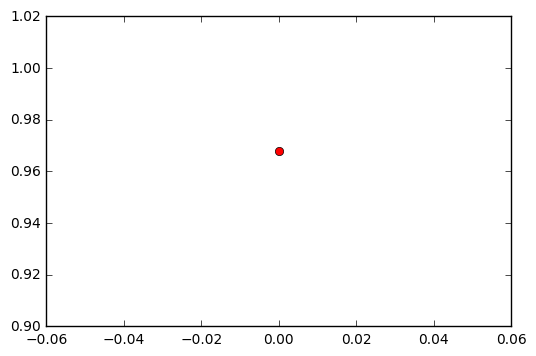

In [17]:
#Hm_2 ->  MU+ NUE  Hm_2 ->  MU+ NUM    Hm_2 ->  MU+ NUT

y = []

num=pd.Series(np.zeros(df.shape[0]))
den=pd.Series(np.zeros(df.shape[0]))
if 'Hm_2 ->  MU+ NUT' in df:
    num = num+df['Hm_2 ->  MU+ NUT']    
if 'Hm_2 ->  MU+ NUM' in df:
    num=num+df['Hm_2 ->  MU+ NUM']
if 'Hm_2 ->  MU+ NUE' in df:
    num=num+df['Hm_2 ->  MU+ NUE']
    
if 'Hm_2 ->  TAUden.shape[0]:+ NUT' in df:
    den = den+df['Hm_2 ->  TAU+ NUT']
if 'Hm_2 ->  TAU+ NUM' in df:
    den=den+df['Hm_2 ->  TAU+ NUM']
if 'Hm_2 ->  TAU+ NUE' in df:
    den=den+df['Hm_2 ->  TAU+ NUE']
if den.unique()[0]:
    y = num/den
else:
    sys.exit('ERROR: No branchings')

plt.plot(df.epsE33,y,'ro')
#plt.loglog(df.epsE33,y,'ro')

[![Home](http://www.incredimail.com/images/nav%20bar/home-icon.png)](./) 
[Jupyter home](./draft.pdf)